In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from uncertainties import ufloat
from uncertainties.umath import sqrt
import scipy.constants as c

1024


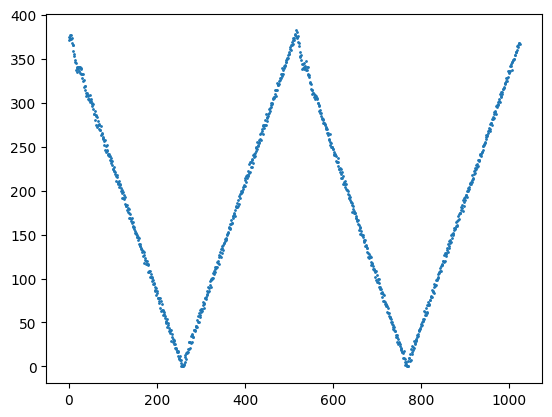

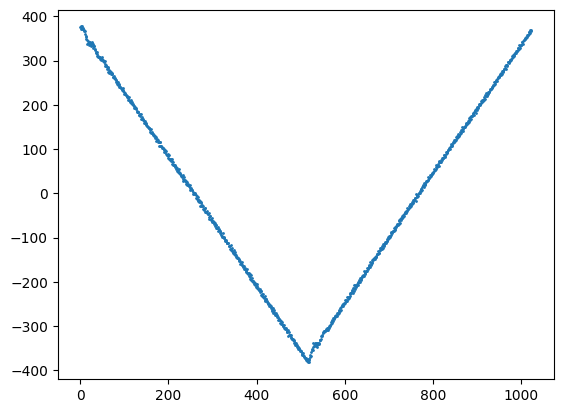

In [2]:
spectrum = np.loadtxt('data/VelocityCalibration_2025-12-15_10-03-29_10_seconds.txt', delimiter = ' ', skiprows = 0)
print(spectrum.shape[0])
plt.scatter(np.arange(spectrum.shape[0]),spectrum,s=1)
#new_spectrum = spectrum[:512] + spectrum[512:]
#plt.scatter(np.arange(spectrum.shape[0]/2),new_spectrum)

plt.show()

new2_spectrum = spectrum
new2_spectrum[int(1024/4):int(1024/4*3)] *= -1

plt.scatter(np.arange(new2_spectrum.shape[0]),new2_spectrum,s=1)





[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 512
    # variables        = 2
    chi-square         = 5388.82864
    reduced chi-square = 10.5663307
    Akaike info crit   = 1209.12445
    Bayesian info crit = 1217.60110
    R-squared          = 0.99977380
[[Variables]]
    slope:     -4.8565e-05 +/- 3.2347e-08 (0.07%) (init = -5e-05)
    intercept:  0.01245760 +/- 9.5478e-06 (0.08%) (init = 0.015)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.8656
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 512
    # variables        = 2
    chi-square         = 5153.93486
    reduced chi-square = 10.1057546
    Akaike info crit   = 1186.30586
    Bayesian info crit = 1194.78251
    R-squared          = 0.99978378
[[Variables]]
    slope:      4.8578e-05 +/- 3.1634e-08 (0.07%) (init = 500000)
    intercept: -0.03733839 +/- 2.4725e-05 (0.07%) 

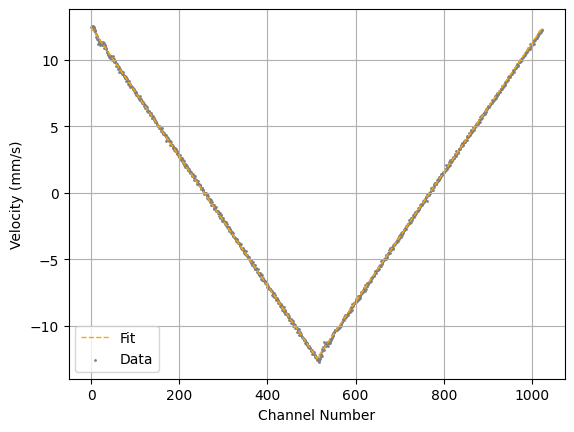

In [3]:
from lmfit.models import LinearModel
from lmfit import Minimizer, report_fit,create_params


model = LinearModel()

spectrum_left = new2_spectrum[:512]
spectrum_right = new2_spectrum[512:]
params_left = create_params(slope = -5e-5, intercept = 0.015)
params_right = create_params(slope=5e5,intercept=-0.03)
#whats the uncertainty on this? idk I think he said about one
y_uncertainty = np.ones(len(spectrum_left))
lambda_0 = 650e-9  # meters
scan_time = 10  # seconds

velocity_left = lambda_0 / (2 * scan_time) *spectrum_left *1024
velocity_right = lambda_0 / (2 * scan_time) *spectrum_right *1024
velocity_uncertainty_left = lambda_0 / (2 * scan_time) * y_uncertainty *1024
velocity_uncertainty_right = lambda_0 / (2 * scan_time) * y_uncertainty *1024






x_data_left = np.arange(spectrum_left.shape[0])
result1 = model.fit(velocity_left, params_left, x=x_data_left, weights=1/velocity_uncertainty_left)
bestfit1 = result1.best_fit
dely1 = result1.eval_uncertainty(sigma=1)



x_data_right = np.arange(spectrum_right.shape[0]) + spectrum_left.shape[0] 
result2 = model.fit(velocity_right,params_right, x= x_data_right, weights = 1/velocity_uncertainty_right)
bestfit2 = result2.best_fit
dely2 = result2.eval_uncertainty(sigma=1)


print(report_fit(result1))
print(report_fit(result2))


results = np.zeros(1024)
results[:512]= bestfit1
results[512:]= bestfit2

result_unc = np.zeros(1024)
result_unc[:512]=dely1
result_unc[512:]=dely2
x_data = np.arange(1024)
plt.plot(x_data,results*10**3,color="orange",label='Fit',linestyle='--',linewidth=1)
plt.ylabel('Velocity (mm/s)')
plt.xlabel('Channel Number')
plt.fill_between(x_data, (results - result_unc)*10**3, (results + result_unc)*10**3, color='gray', alpha=0.5)
plt.scatter(x_data, new2_spectrum * lambda_0 / (2 * scan_time) * 1024 *10**3, s=1, color='gray', label='Data')
plt.legend()
plt.grid()
plt.show()
#print(results)

data_to_save = np.column_stack((x_data, results, result_unc))
np.savetxt('fit_results.csv', data_to_save, delimiter=',', 
           header='x,y_fit,uncertainty', comments='')

